In [1]:
import pandas as pd
import numpy as np
import shap
import json
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [ ]:
# load dataset
df = pd.read_csv('../../../../datasets/atis_dataset_preprocessed.csv', sep=';')

In [ ]:
# define label columns
label_columns = ['ILS', 'RNAV', 'RNP', 'VISUAL']

# define features and targets
X = df.drop(columns=label_columns + ['airport_icao', 'runway_designator_number', 'runway_designator_side', 'runway_ils_category'])

# one-hot encode features that are categorical
X = pd.get_dummies(X, columns=['weather_phenomenon', 'rvr_tendency'])

In [4]:
y = df[label_columns]

In [5]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

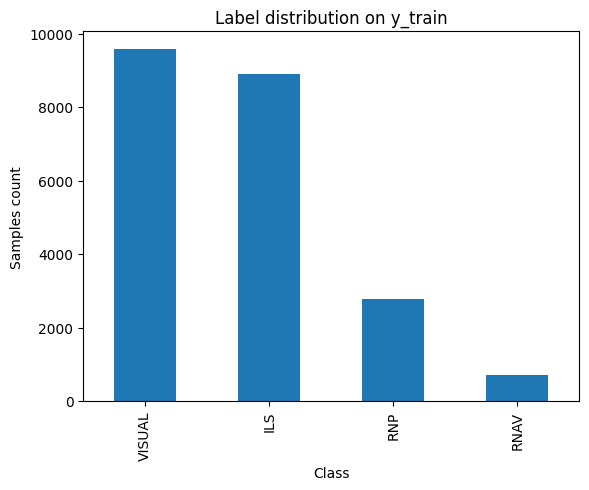

Label distribution:
 VISUAL    9576
ILS       8904
RNP       2782
RNAV       698
dtype: int64


In [6]:
# check for label distribution
label_counts = y_train.sum().sort_values(ascending=False)
label_counts.plot(kind='bar')
plt.title('Label distribution on y_train')
plt.xlabel('Class')
plt.ylabel('Samples count')
plt.show()

print("Label distribution:\n", label_counts)

In [7]:
# oversampling imbalanced labels
try:
    X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
    print("SMOTE successful. X_train after SMOTE:", X_train_sm.shape)
    print("Label distribution after SMOTE:\n", pd.DataFrame(y_train_sm, columns=label_columns).sum())
    X_train_use, y_train_use = X_train_sm, y_train_sm
except Exception as e:
    print("SMOTE failed for multi-label")
    X_train_use, y_train_use = X_train, y_train

SMOTE failed for multi-label


In [8]:
# build and train multi-label model
base_model = OneVsRestClassifier(XGBClassifier(eval_metric='logloss'))

# hyperparameter tuning
params = {
    'estimator__n_estimators': [100, 200],
    'estimator__learning_rate': [0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.7, 1.0],
    'estimator__colsample_bytree': [0.7, 1.0],
    'estimator__gamma': [0, 1],
    'estimator__reg_alpha': [0, 1],
    'estimator__reg_lambda': [0, 1],
    'estimator__min_child_weight': [1, 3],
}

search = GridSearchCV(
    estimator=base_model,
    param_grid=params,
    cv=3,
    scoring='f1_micro',
    verbose=2,
    n_jobs=1
)

# build and train multi-label model
search.fit(X_train, y_train)

# pick the best model
model = search.best_estimator_

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
[CV] END estimator__colsample_bytree=0.7, estimator__gamma=0, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__reg_alpha=0, estimator__reg_lambda=0, estimator__subsample=0.7; total time=   0.7s
[CV] END estimator__colsample_bytree=0.7, estimator__gamma=0, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__reg_alpha=0, estimator__reg_lambda=0, estimator__subsample=0.7; total time=   0.7s
[CV] END estimator__colsample_bytree=0.7, estimator__gamma=0, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__reg_alpha=0, estimator__reg_lambda=0, estimator__subsample=0.7; total time=   0.8s
[CV] END estimator__colsample_bytree=0.7, estimator__gamma=0, estimator__learning_rate=0.05, estimator__max_depth=3, estim

In [9]:
print(search.best_params_)

{'estimator__colsample_bytree': 1.0, 'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__min_child_weight': 1, 'estimator__n_estimators': 200, 'estimator__reg_alpha': 1, 'estimator__reg_lambda': 1, 'estimator__subsample': 1.0}


In [10]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__colsample_bytree,param_estimator__gamma,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__min_child_weight,param_estimator__n_estimators,param_estimator__reg_alpha,param_estimator__reg_lambda,param_estimator__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
847,0.963409,0.054806,0.054759,0.002361,1.0,0,0.2,7,1,200,1,1,1.0,"{'estimator__colsample_bytree': 1.0, 'estimato...",0.924717,0.918145,0.920529,0.921130,0.002716,1
843,0.932905,0.040044,0.061831,0.006469,1.0,0,0.2,7,1,200,0,1,1.0,"{'estimator__colsample_bytree': 1.0, 'estimato...",0.924568,0.918149,0.918736,0.920484,0.002898,2
169,1.505377,0.072048,0.087141,0.004707,0.7,0,0.1,7,1,200,0,0,1.0,"{'estimator__colsample_bytree': 0.7, 'estimato...",0.924057,0.919070,0.918229,0.920452,0.002573,3
173,0.929816,0.074391,0.047096,0.002899,0.7,0,0.1,7,1,200,1,0,1.0,"{'estimator__colsample_bytree': 0.7, 'estimato...",0.922701,0.918028,0.920426,0.920385,0.001908,4
837,0.600406,0.092846,0.049052,0.008578,1.0,0,0.2,7,1,100,1,0,1.0,"{'estimator__colsample_bytree': 1.0, 'estimato...",0.924391,0.917711,0.918431,0.920178,0.002994,5


In [ ]:
# save trained model
with open("../../trained_models/model-xgb-ovr-GS-no_airport_feats.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
# features in order
feature_order = list(X.columns)

# save to json
with open("../../feature_order/feature_order_xgb_ovr_GS_no_airport_feats.json", "w") as f:
    json.dump(feature_order, f)

In [13]:
# predict and evaluate
y_pred = model.predict(X_test)
empty_mask = y_pred.sum(axis=1) == 0
no_predictions = np.sum(empty_mask)
print(f"Samples with no predicted labels: {no_predictions} out of {len(y_pred)}")
print(X_test[empty_mask])
print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Samples with no predicted labels: 34 out of 3819
       visibility  wind_speed  wind_gust  wind_direction     rvr  headwind  \
7496         10.0          12          0             170  6000.0      -4.1   
12911        10.0           8          0             210  6000.0       7.9   
11323        10.0           8          0             280  6000.0       8.0   
7613          9.0           3          0             130  6000.0       2.6   
4336         10.0          11          0             240  5500.0       8.4   
8875         10.0           8          0             270  6000.0       7.9   
6472         10.0          12          0             250  6000.0      10.4   
16008        10.0          10          0             120  6000.0      -1.7   
5168         10.0           8          0             280  6000.0       8.0   
3507         10.0           6          0             130  6000.0      -5.2   
8883         10.0           8          0             270  6000.0       7.9   
16285        10

C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


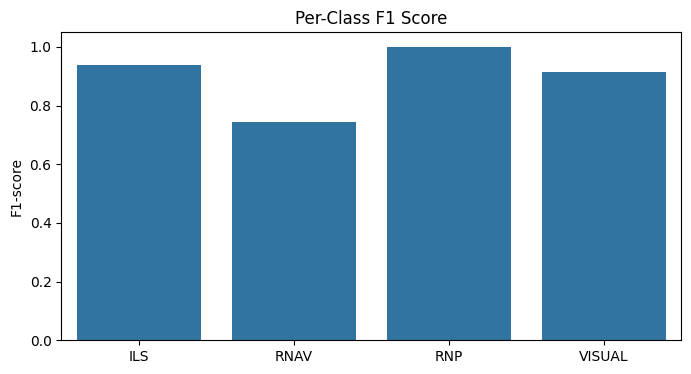

In [14]:
# per-class F1-score bar chart
report = classification_report(y_test, y_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(len(label_columns))]
plt.figure(figsize=(8,4))
sns.barplot(x=label_columns, y=f1_scores)
plt.title("Per-Class F1 Score")
plt.ylabel("F1-score")
plt.show()

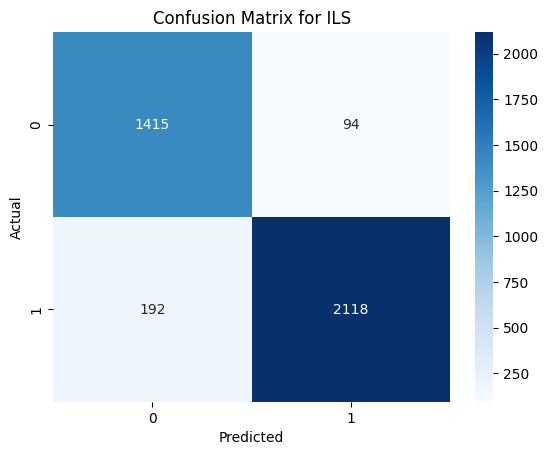

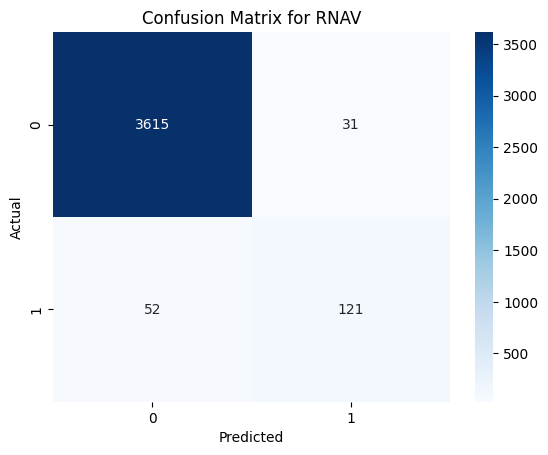

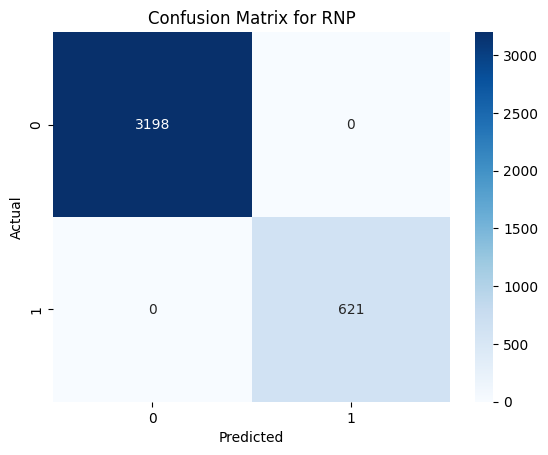

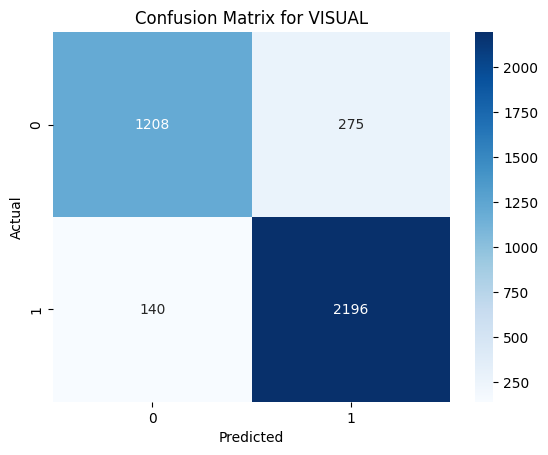

In [15]:
# confusion matrix per label
cm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(label_columns):
    plt.figure()
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

SHAP summary plot for ILS


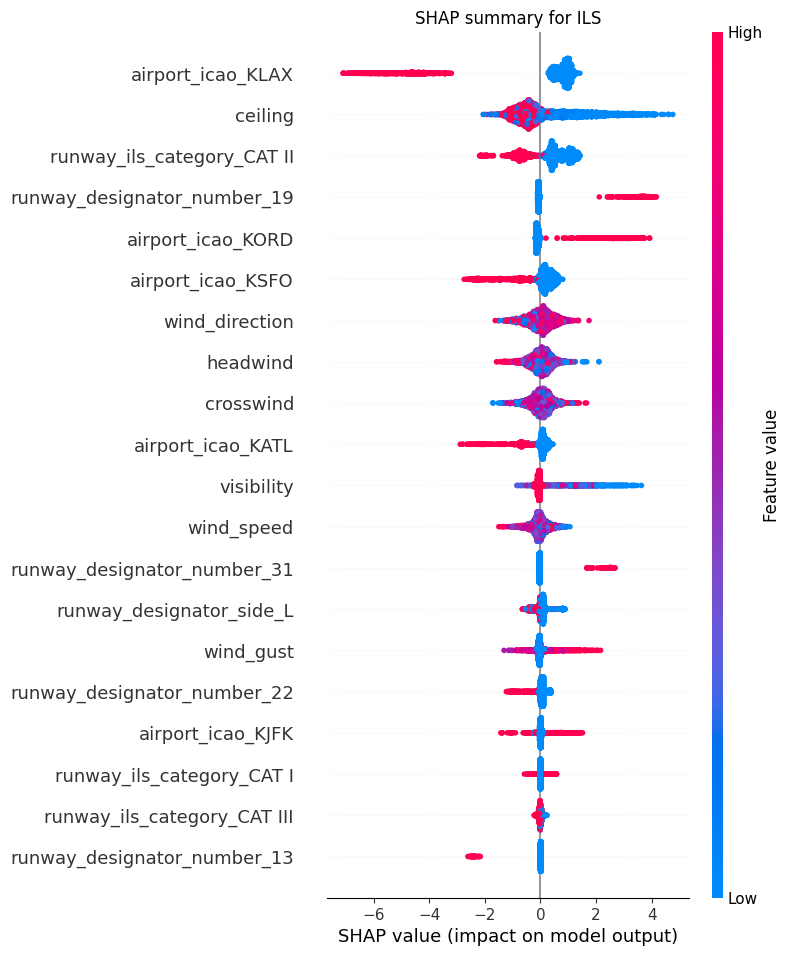

SHAP summary plot for RNAV


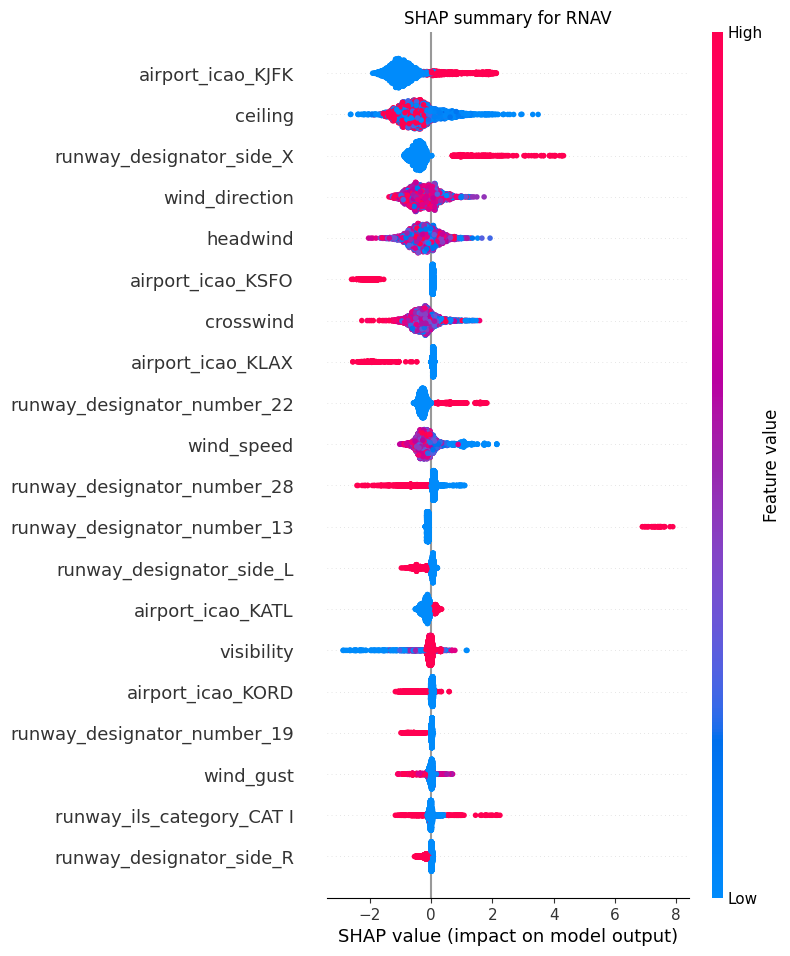

SHAP summary plot for RNP


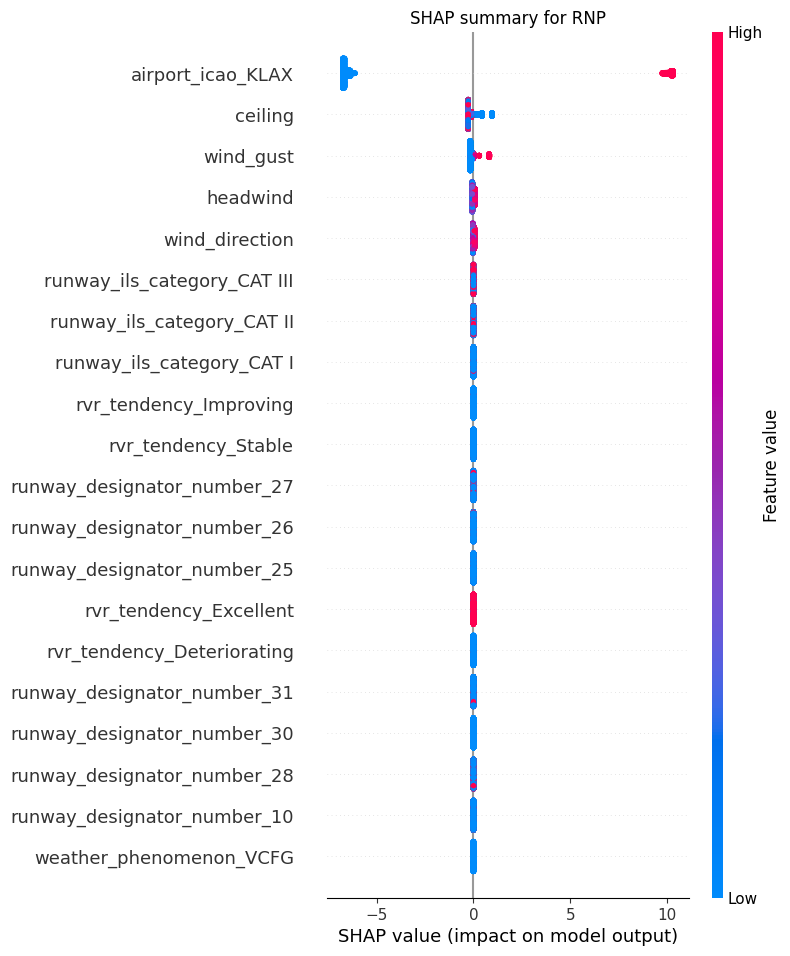

SHAP summary plot for VISUAL


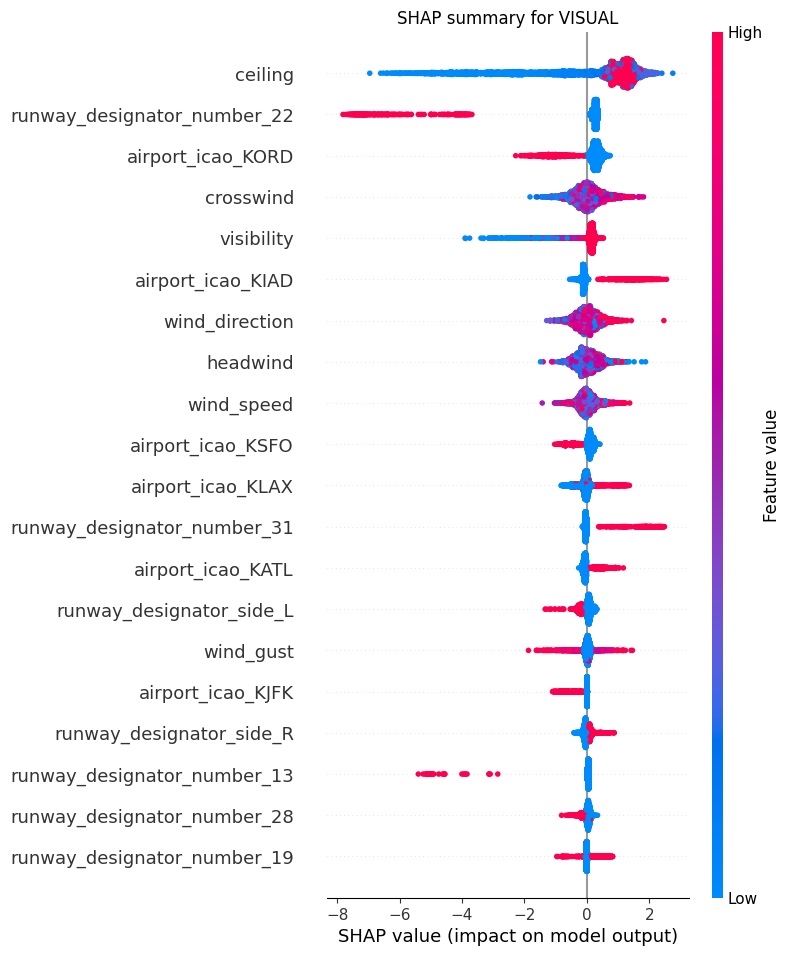

In [16]:
# SHAP summary plot per label
for idx, label in enumerate(label_columns):
    print(f"SHAP summary plot for {label}")
    explainer = shap.TreeExplainer(model.estimators_[idx])
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP summary for {label}")
    plt.show()

In [17]:
# false predictions cases
for i, label in enumerate(label_columns):
    false_positives = np.where((y_test[label].values == 0) & (y_pred[:, i] == 1))[0]
    false_negatives = np.where((y_test[label].values == 1) & (y_pred[:, i] == 0))[0]
    print(f"\n{label} False Positives (max 5):")
    display(X_test.iloc[false_positives[:5]])
    print(f"{label} False Negatives (max 5):")
    display(X_test.iloc[false_negatives[:5]])


ILS False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
466,10.0,6,0,100,6000.0,-3.0,-5.2,10000,False,False,...,False,False,False,False,True,False,False,False,False,True
4509,10.0,11,0,200,6000.0,1.9,-10.8,20000,False,False,...,True,False,False,False,True,False,False,False,True,False
18371,10.0,18,0,250,6000.0,15.6,-9.0,1300,False,False,...,True,False,False,False,True,False,False,False,True,False
5155,10.0,9,0,280,6000.0,6.9,5.8,99999,False,False,...,False,False,False,False,True,False,False,False,False,True
17495,10.0,7,0,210,6000.0,6.9,-1.2,9500,False,False,...,False,False,False,False,True,False,False,False,False,True


ILS False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
5922,10.0,10,0,260,6000.0,9.4,-3.4,20000,False,False,...,True,False,False,False,True,False,False,False,True,False
15734,10.0,3,0,-1,6000.0,-0.5,3.0,6500,True,False,...,False,False,False,False,True,False,False,False,True,False
9149,10.0,4,0,60,6000.0,-3.1,2.6,99999,False,False,...,True,False,False,False,True,False,False,False,True,False
13485,10.0,6,0,220,6000.0,3.0,-5.2,99999,True,False,...,True,False,False,False,True,False,False,False,True,False
115,10.0,8,0,170,6000.0,5.1,-6.1,23000,False,False,...,False,False,False,False,True,False,False,False,False,True



RNAV False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
16049,10.0,7,0,120,6000.0,-1.2,-6.9,1600,False,False,...,False,False,False,False,True,False,False,False,False,True
7499,10.0,8,0,110,6000.0,7.9,1.4,25000,True,False,...,False,False,False,False,True,False,False,False,False,True
115,10.0,8,0,170,6000.0,5.1,-6.1,23000,False,False,...,False,False,False,False,True,False,False,False,False,True
16274,10.0,15,0,180,6000.0,11.5,-9.6,99999,False,False,...,False,False,False,False,True,False,False,False,False,True
4148,10.0,8,0,110,6000.0,7.9,1.4,25000,True,False,...,False,False,False,False,True,False,False,False,False,True


RNAV False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
14378,7.0,6,0,140,6000.0,4.6,3.9,15000,True,False,...,False,False,False,False,True,False,False,False,False,True
466,10.0,6,0,100,6000.0,-3.0,-5.2,10000,False,False,...,False,False,False,False,True,False,False,False,False,True
11729,10.0,12,0,200,6000.0,11.3,-4.1,8500,False,False,...,False,False,False,False,True,False,False,False,False,True
8242,10.0,11,0,160,6000.0,5.5,9.5,7000,True,False,...,False,False,False,False,True,False,False,False,False,True
17495,10.0,7,0,210,6000.0,6.9,-1.2,9500,False,False,...,False,False,False,False,True,False,False,False,False,True



RNP False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III


RNP False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III



VISUAL False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
5922,10.0,10,0,260,6000.0,9.4,-3.4,20000,False,False,...,True,False,False,False,True,False,False,False,True,False
15734,10.0,3,0,-1,6000.0,-0.5,3.0,6500,True,False,...,False,False,False,False,True,False,False,False,True,False
4073,10.0,8,0,150,6000.0,5.1,6.1,99999,False,False,...,False,False,False,False,True,False,False,False,False,True
2129,10.0,9,18,280,6000.0,8.5,3.1,5500,True,False,...,False,False,False,False,True,False,False,False,True,False
14378,7.0,6,0,140,6000.0,4.6,3.9,15000,True,False,...,False,False,False,False,True,False,False,False,False,True


VISUAL False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
13740,10.0,5,0,190,6000.0,0.9,-4.9,8000,True,False,...,False,False,False,False,True,False,False,False,True,False
2221,10.0,14,23,300,6000.0,13.2,4.8,99999,False,False,...,True,False,False,False,True,False,False,False,False,True
3323,10.0,14,25,210,6000.0,4.8,-13.2,25000,False,False,...,True,False,False,False,True,False,False,False,False,True
5863,10.0,8,0,310,6000.0,6.9,4.0,99999,False,False,...,True,False,False,False,True,False,False,False,False,True
11323,10.0,8,0,280,6000.0,8.0,0.0,99999,False,False,...,True,False,False,False,True,False,False,False,True,False
